In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import scipy.stats as stats
from statistics import mean
from datetime import datetime, timedelta

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, extract

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurements = Base.classes.measurement
Stations = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

SELECT date(max(measurement.date), :date_2) AS date_1, max(measurement.date) AS max_1 
FROM measurement

start date: 2016-08-23, finish date: 2017-08-23

SELECT measurement.date, measurement.prcp 
FROM measurement 
WHERE measurement.date >= :date_1 AND measurement.date <= :date_2 ORDER BY measurement.date



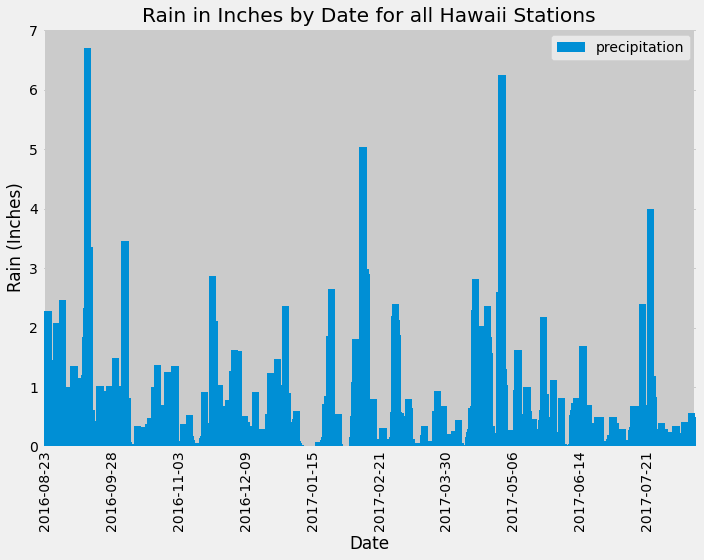

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
query = session.query(func.date(func.max(Measurements.date), '-12 months'), func.max(Measurements.date)) 
print(query.statement.compile())
print("")
start_date, finish_date  = query.first()
print(f"start date: {start_date}, finish date: {finish_date}")
print("")

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurements.date, Measurements.prcp).\
    filter(Measurements.date >= start_date, Measurements.date <= finish_date).\
    order_by(Measurements.date)
print(query.statement.compile())
print("")
results = query.all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date','precipitation'])
df.set_index("date", inplace=True)


# Sort the dataframe by date
df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
ax = df.plot.bar(figsize=(10,8), width=25, grid=True)
ax.set_title("Rain in Inches by Date for all Hawaii Stations")
ax.set_ylabel("Rain (Inches)")
ax.set_xlabel("Date")
xticks = ax.xaxis.get_major_ticks()
for i in range(0, len(xticks)):
     if i % 230 != 0:
         xticks[i].label1.set_visible(False)
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
query = session.query(Stations.station, Stations.name)
print(query.statement.compile()) 
print("")
stations = query.all()
for station, name in stations:
    print(f"station name: {name}")
print(f"\nNumber of stations available and used in this dataset: {len(stations)}")

SELECT station.station, station.name 
FROM station

station name: WAIKIKI 717.2, HI US
station name: KANEOHE 838.1, HI US
station name: KUALOA RANCH HEADQUARTERS 886.9, HI US
station name: PEARL CITY, HI US
station name: UPPER WAHIAWA 874.3, HI US
station name: WAIMANALO EXPERIMENTAL FARM, HI US
station name: WAIHEE 837.5, HI US
station name: HONOLULU OBSERVATORY 702.2, HI US
station name: MANOA LYON ARBO 785.2, HI US

Number of stations available and used in this dataset: 9


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
query = session.query(Measurements.station, Stations.name, func.count(Measurements.tobs)).\
    filter(Measurements.station == Stations.station).\
    group_by(Measurements.station).\
    order_by(func.count(Measurements.tobs).desc())
             
print(query.statement.compile()) 
print("")

active_stations = query.all()

active_stations_df = pd.DataFrame(active_stations, columns=['station', 'name', 'count'])
active_stations_df

SELECT measurement.station, station.name, count(measurement.tobs) AS count_1 
FROM measurement, station 
WHERE measurement.station = station.station GROUP BY measurement.station ORDER BY count(measurement.tobs) DESC



,station,name,count
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,USC00517948,"PEARL CITY, HI US",1372
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
highest_station_id = active_stations_df.loc[0, 'station']
print(f"highest station: {highest_station_id}\n")

query = session.query(Measurements.station, Stations.name, func.min(Measurements.tobs), func.max(Measurements.tobs), func.avg(Measurements.tobs) ).\
    filter(Measurements.station == Stations.station, Measurements.station == highest_station_id).\
    group_by(Measurements.station)

print(query.statement.compile())
print("")

station, station_name, lowest_temp, highest_temp, avg_temp = query.first()
print(f"{station_name} low temp: {lowest_temp}, average temp: {avg_temp}, high temp: {highest_temp}")


highest station: USC00519281

SELECT measurement.station, station.name, min(measurement.tobs) AS min_1, max(measurement.tobs) AS max_1, avg(measurement.tobs) AS avg_1 
FROM measurement, station 
WHERE measurement.station = station.station AND measurement.station = :station_1 GROUP BY measurement.station

WAIHEE 837.5, HI US low temp: 54.0, average temp: 71.66378066378067, high temp: 85.0


SELECT date(max(measurement.date), :date_2) AS date_1, max(measurement.date) AS max_1 
FROM measurement 
WHERE measurement.station = :station_1

start date: 2016-08-18, finish date: 2017-08-18

SELECT measurement.date, measurement.tobs 
FROM measurement 
WHERE measurement.date >= :date_1 AND measurement.date <= :date_2 AND measurement.station = :station_1 ORDER BY measurement.date



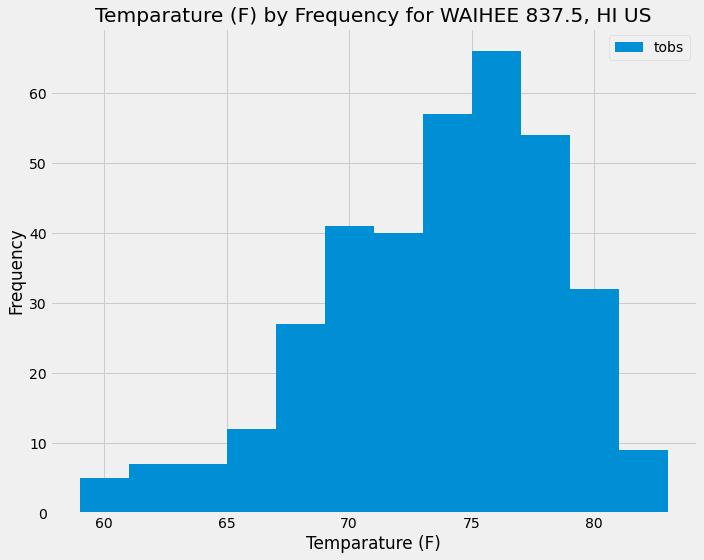

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = session.query(func.date(func.max(Measurements.date), '-12 months'), func.max(Measurements.date)).\
    filter(Measurements.station == highest_station_id)
print(query.statement.compile())
print("")
start_date, finish_date  = query.first()
print(f"start date: {start_date}, finish date: {finish_date}")
print("")

query = session.query(Measurements.date, Measurements.tobs).\
    filter(Measurements.date >= start_date, Measurements.date <= finish_date).\
    filter(Measurements.station == highest_station_id).\
    order_by(Measurements.date)
print(query.statement.compile())
print("")
results = query.all()

# Save the query results as a Pandas DataFrame and set the index to the date column
temp_df = pd.DataFrame(results, columns=['date','tobs'])
temp_df.set_index("date", inplace=True)

ax = temp_df.plot.hist(bins=12, figsize=(10,8))
ax.set_title(f"Temparature (F) by Frequency for {station_name}")
ax.set_ylabel("Frequency")
ax.set_xlabel("Temparature (F)")
plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

SELECT measurement.tobs 
FROM measurement 
WHERE EXTRACT(month FROM measurement.date) = :param_1



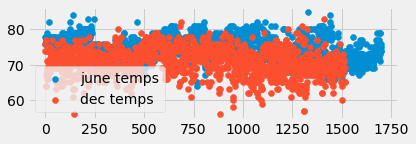

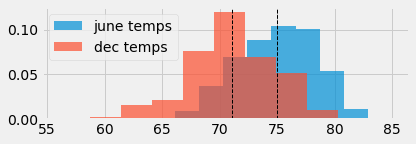

Ttest_indResult(statistic=31.355036920962423, pvalue=4.193529835915755e-187)

In [16]:
# Calculate the ttest for the two given months
# Identify the average temperature in June at all stations across all available years in the dataset.
# Do the same for December temperature.

query = session.query(Measurements.tobs).filter(extract('month', Measurements.date) == 6) 
results = query.all()
june_list = list(np.ravel(results))

query = session.query(Measurements.tobs).filter(extract('month', Measurements.date) == 12) 
print(query.statement.compile())
print("")
results = query.all()
dec_list = list(np.ravel(results))

plt.subplot(2, 1, 1)
plt.scatter(range(len(june_list)), june_list, label="june temps")
plt.scatter(range(len(dec_list)), dec_list, label="dec temps")
plt.legend()
plt.tight_layout()
plt.show()

plt.subplot(2, 1, 2)
plt.hist(june_list, 10, density=True, alpha=0.7, label="june temps")
plt.hist(dec_list, 10, density=True, alpha=0.7, label="dec temps")
plt.axvline(mean(june_list), color='k', linestyle='dashed', linewidth=1)
plt.axvline(mean(dec_list), color='k', linestyle='dashed', linewidth=1)
plt.legend()  
plt.tight_layout()
plt.show()

stats.ttest_ind(june_list, dec_list, equal_var=False)

#
# Based on the charts and ttest results below temperatures are statistically different between June and December
# As such we can reject the null hypothesis
#
# I chose to use the two sample t-test because I have 2 independent groups

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).filter(Measurements.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_vacy = '2017-03-15'
end_vacy = '2017-03-30'

previous_year_start = session.query(func.date(start_vacy, '-12 months')).first()[0]
previous_year_end = session.query(func.date(end_vacy, '-12 months')).first()[0]

results = calc_temps(previous_year_start, previous_year_end)
t_min = results[0][0]
t_avg = results[0][1]
t_max = results[0][2]
print(t_min, t_avg, t_max)

62.0 70.6969696969697 82.0


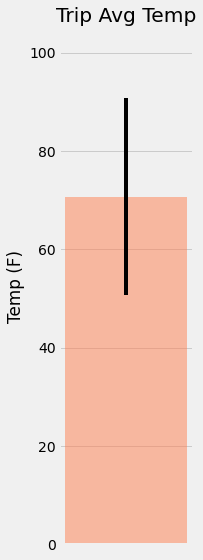

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=(3,8))
ax.bar(1, t_avg, yerr=t_max-t_min, align='center',color='coral', alpha=0.5)
ax.set_xticks([])
ax.set_title('Trip Avg Temp')
ax.set_ylim([0,105])
ax.set_ylabel('Temp (F)')
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Stations.station, Stations.name, Stations.latitude, Stations.longitude, Stations.elevation, func.avg(Measurements.prcp)]
query = session.query(*sel).\
    filter(Measurements.station == Stations.station).\
    filter(Measurements.date >= previous_year_start).\
    filter(Measurements.date <= previous_year_end).\
    group_by(Measurements.station).\
    order_by(func.avg(Measurements.prcp).desc())
print(query.statement.compile())
print("")
results = query.all()
vacy_df = pd.DataFrame(results, columns=['Station', 'Name', 'Latitude', 'Longitude', 'Elevation', 'Avg Precipitation'])
vacy_df

SELECT station.station, station.name, station.latitude, station.longitude, station.elevation, avg(measurement.prcp) AS avg_1 
FROM station, measurement 
WHERE measurement.station = station.station AND measurement.date >= :date_1 AND measurement.date <= :date_2 GROUP BY measurement.station ORDER BY avg(measurement.prcp) DESC



,Station,Name,Latitude,Longitude,Elevation,Avg Precipitation
0,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.340625
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.148571
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.143125
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.104545
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.092500
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.021250
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.000000


In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurements.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
date_list = []
full_date_list = []
start_date = datetime.strptime(start_vacy, '%Y-%m-%d').date()
end_date = datetime.strptime(end_vacy, '%Y-%m-%d').date()
delta = timedelta(days=1)

while start_date <= end_date:
    full_date_list.append(start_date)
    date_list.append(datetime.strftime(start_date, '%m-%d'))
    start_date += delta

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for vacy_date in date_list:
    normals.append(daily_normals(vacy_date)[0])

In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['tmin','tavg', 'tmax'])
normals_df['date'] = full_date_list
normals_df.set_index('date', inplace=True)
normals_df

,tmin,tavg,tmax
date,,,
2017-03-15,58.0,68.547170,76.0
2017-03-16,60.0,69.703704,78.0
2017-03-17,57.0,68.540000,75.0
2017-03-18,57.0,67.784314,76.0
2017-03-19,60.0,69.100000,75.0
2017-03-20,62.0,70.117647,80.0
2017-03-21,60.0,71.076923,77.0
2017-03-22,65.0,71.754717,77.0
2017-03-23,63.0,70.796296,78.0


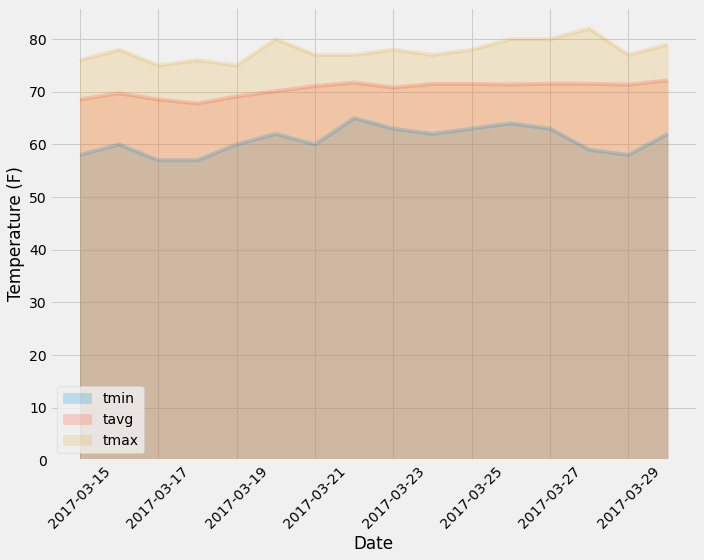

In [24]:
# Plot the daily normals as an area plot with `stacked=False`
ax = normals_df.plot.area(alpha=0.22, stacked=False, rot=45, figsize=(10,8))
ax.set_ylabel('Temperature (F)')
ax.set_xlabel('Date')
ax.legend(loc='lower left')
ax.grid(True)
plt.tight_layout()
plt.show()

In [25]:
# close the database session
session.close()